# Twitch Streamer Partnership 
***
by Griffin Hundley

![](images/twitch-generic-email-1-1-1-1.jpg)

## Overview

Twitch is a social platform for livestreaming video games, music, art, and more.  For most people making content on the platform, livestreaming started out as a hobby for people sharing their love of gaming - something they do only because its fun.  For a select few who build a strong community and gain a larger audience, they can turn their channel into a primary source of income by becoming a partner with Twitch.

Being a partner has a lot of perks, but also a few restrictions.  Partners get a subscription button added to their channel, where viewers can pay $5 for 1 month access to subscriber-only emotes, don't have to watch advertisements, and receive channel specific rewards.  Partners also get a share of the revenue for ads ran on their channel.  As part of the contract that partners sign, they cannot livestream on other platforms.

As of February 2020, there are 3.8 million unique broadcasters on the website, with an average of 56,000 concurrent broadcasters, and 1.44 million concurrent viewers at a given time.  Of those 3.8 million broadcasters, there are roughly 41,000 partners. 

Source: Mansoor Iqbal https://www.businessofapps.com/data/twitch-statistics/

***

## Business Problem

![](images/twitch-average-monthly-broadcasters.png)

Source: Mansoor Iqbal https://www.businessofapps.com/data/twitch-statistics/

Livestreaming is emerging as a premiere online industry, with significant growth over the years.  As of December 2020, the effects of COVID are still being realized, however there are reports of 24-50% increase in Twitch viewership as a result of the pandemic lockdowns.

Online entertainment isn't going anywhere but up.  As a result of increasing scale, more online companies must rely on automated systems.  For example - Twitch competitors Youtube Live and Facebook Gaming use automated systems to detect copywrite infringment and obscene content.  As the number of broadcasters and viewers continues to rise, and as the entertainment industry shifts more online, the number of people turning to livestreaming as a source of income increases.  

Applications for partnership are currently reviewed manually by Twitch staff, with applicants waiting 2-4 weeks to get results.  Because partnership is approved manually by different individuals, there can be a personal selective bias towards or against certain demographics.  In some cases, very successful streamers with well above average metrics have been denied partnership, while much smaller channels are approved, leading to distrust between the broadcaster and Twitch.  

The goal of this analysis is to provide a model that can approve or deny channels for partnership based on their channel metrics, removing the need for manual review, which frees up resources, decreases feedback time to streamers on the status of their partnership application, and having a system without personal influences.  Additionally, the nature of the model allows for dynamically adjusting the threshold for approval, to make it more or less strict depending on the needs of Twitch.

Source: Thomas Wilde https://www.geekwire.com/2020/twitch-sets-audience-record-october-pandemic-continues-fuel-livestreaming-growth/

***

## Data

Over the course of a week, at different times during the day, the Twitch API was queried through all of the pages of currently live broadcasters to generate a list of \~800,000 broadcasters.  These broadcasters were then filtered to only channels older than 60 days, with over 900 viewers (\~300,000 broadcasters).  This is to filter out brand new channels, and only to examine channels that meet the basic number of viewers to be considered for partnership as described in the Path to Partnership achievement. From the twitch api, the data being collected covers:

```view_count```: total number of lifetime channel views

```account_age```: time since account creation

```broadcaster_type```: (partner, affiliate, unaffiliated)

From these \~300K broadcasters, a random sample of 10% of those channels (\~30k) was chosen to obtain a reasonably sized dataset.  For these \~30k channels, data was webscraped from twitchtracker.com.  The channel metrics being examined are lifetime aggregate channel data.  The specific metrics gathered are:

```hours_streamed```: total number of hours stream has been live

```average_viewers```: average number of concurrent viewers

```peak_viewers```: peak number of concurrent viewers

```days_of_activity```: total number of days where stream was live

```total_games_streamed```: total number of games streamed

```daily_broadcast_time```:  average hours channel is live per day

```hours_watched_daily```: average number of hours watched by viewers per day

```followers_per_stream```: average number of followers gained per stream

```views_per_stream```: average number of concurrent viewers per stream

```followers_per_hour```: average number of followers per hour

```views_per_hour```: average number of views per hour

```hours_watched```: total hours watched by viewers

```active_days_per_week```: average of how many days per week the broadcast is live

```average_games```:  average number of games played per stream
***

### Data Assumptions

A key assumption being made with this analysis is that a channel's total lifetime aggregate metrics can be used to classify a channel by partnership.  Not having access to the date when a channel is partnered, analysis can only be made on the metrics as they currently are, not when the channel was partnered.  As a result, theoretically this biased analysis should produce a harsher classifier, with the idea that once a channel is partnered it will continue to grow and inflate its metrics, and by association inflate the decision boundary.  If a model produced from this analysis were to be used by Twitch in its partnership approval process, in deployment, Twitch would have access to those specific metrics and would not have this bias. 

Features not used in this analysis that Twitch currently uses in their partner selection is chat interaction - how active are the viewers in the chat room.  This information would theoretically be important to classifying small streams, as a small stream with a very active chat could be partners.

Additionally, Twitch makes a distinction between 'natural' views and views gained through hosts and raids (when one channel sends all of its viewers to another channel, and only natural views count towards their decision.  This analysis has no method of identifying natural views from views gained through hosts or raids, and will assume that views are natural.  The theoretical effect of this assumption is a slight deflation of importance in view-related features.

## EDA

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('./data/streamer_data.csv')
df = df.drop(columns = ['game_name', 'login', 'broadcaster_type', 'language'])
df.account_age = pd.to_timedelta(df.account_age).map(lambda x: x.days)
labels = df.columns

In [4]:
df.head()

,view_count,account_age,hours_streamed,average_viewers,peak_viewers,days_of_activity,total_games_streamed,daily_broadcast_time,hours_watched_daily,followers_per_stream,views_per_stream,followers_per_hour,views_per_hour,hours_watched,followers_to_date,active_days_per_week,average_games,is_affiliate,target
0,223617671,2271,12329,18713,222720,1384,666,9,166694,3038,160973,342,18123,230704779,4220004,6.6,3.0,1,1
1,27590075,1330,969,1764,35156,421,25,2,4060,474,62976,213,28334,1709463,207022,2.3,1.1,1,1
2,54364251,893,2495,13559,90006,647,16,4,52287,4128,83720,1083,21978,33829930,2703816,5.1,1.1,1,1
3,37392445,983,6486,8362,226974,907,139,7,59797,851,38627,129,5860,54235792,837350,6.4,1.6,1,1
4,3973820,146,468,6703,19128,107,17,4,29341,3467,46531,644,8643,3139461,303362,5.0,1.5,0,0


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29538 entries, 0 to 29537
Data columns (total 19 columns):
view_count              29538 non-null int64
account_age             29538 non-null int64
hours_streamed          29538 non-null int64
average_viewers         29538 non-null int64
peak_viewers            29538 non-null int64
days_of_activity        29538 non-null int64
total_games_streamed    29538 non-null int64
daily_broadcast_time    29538 non-null int64
hours_watched_daily     29538 non-null int64
followers_per_stream    29538 non-null int64
views_per_stream        29538 non-null int64
followers_per_hour      29538 non-null int64
views_per_hour          29538 non-null int64
hours_watched           29538 non-null int64
followers_to_date       29538 non-null int64
active_days_per_week    29538 non-null float64
average_games           29538 non-null float64
is_affiliate            29538 non-null int64
target                  29538 non-null int64
dtypes: float64(2), int64(17)
me

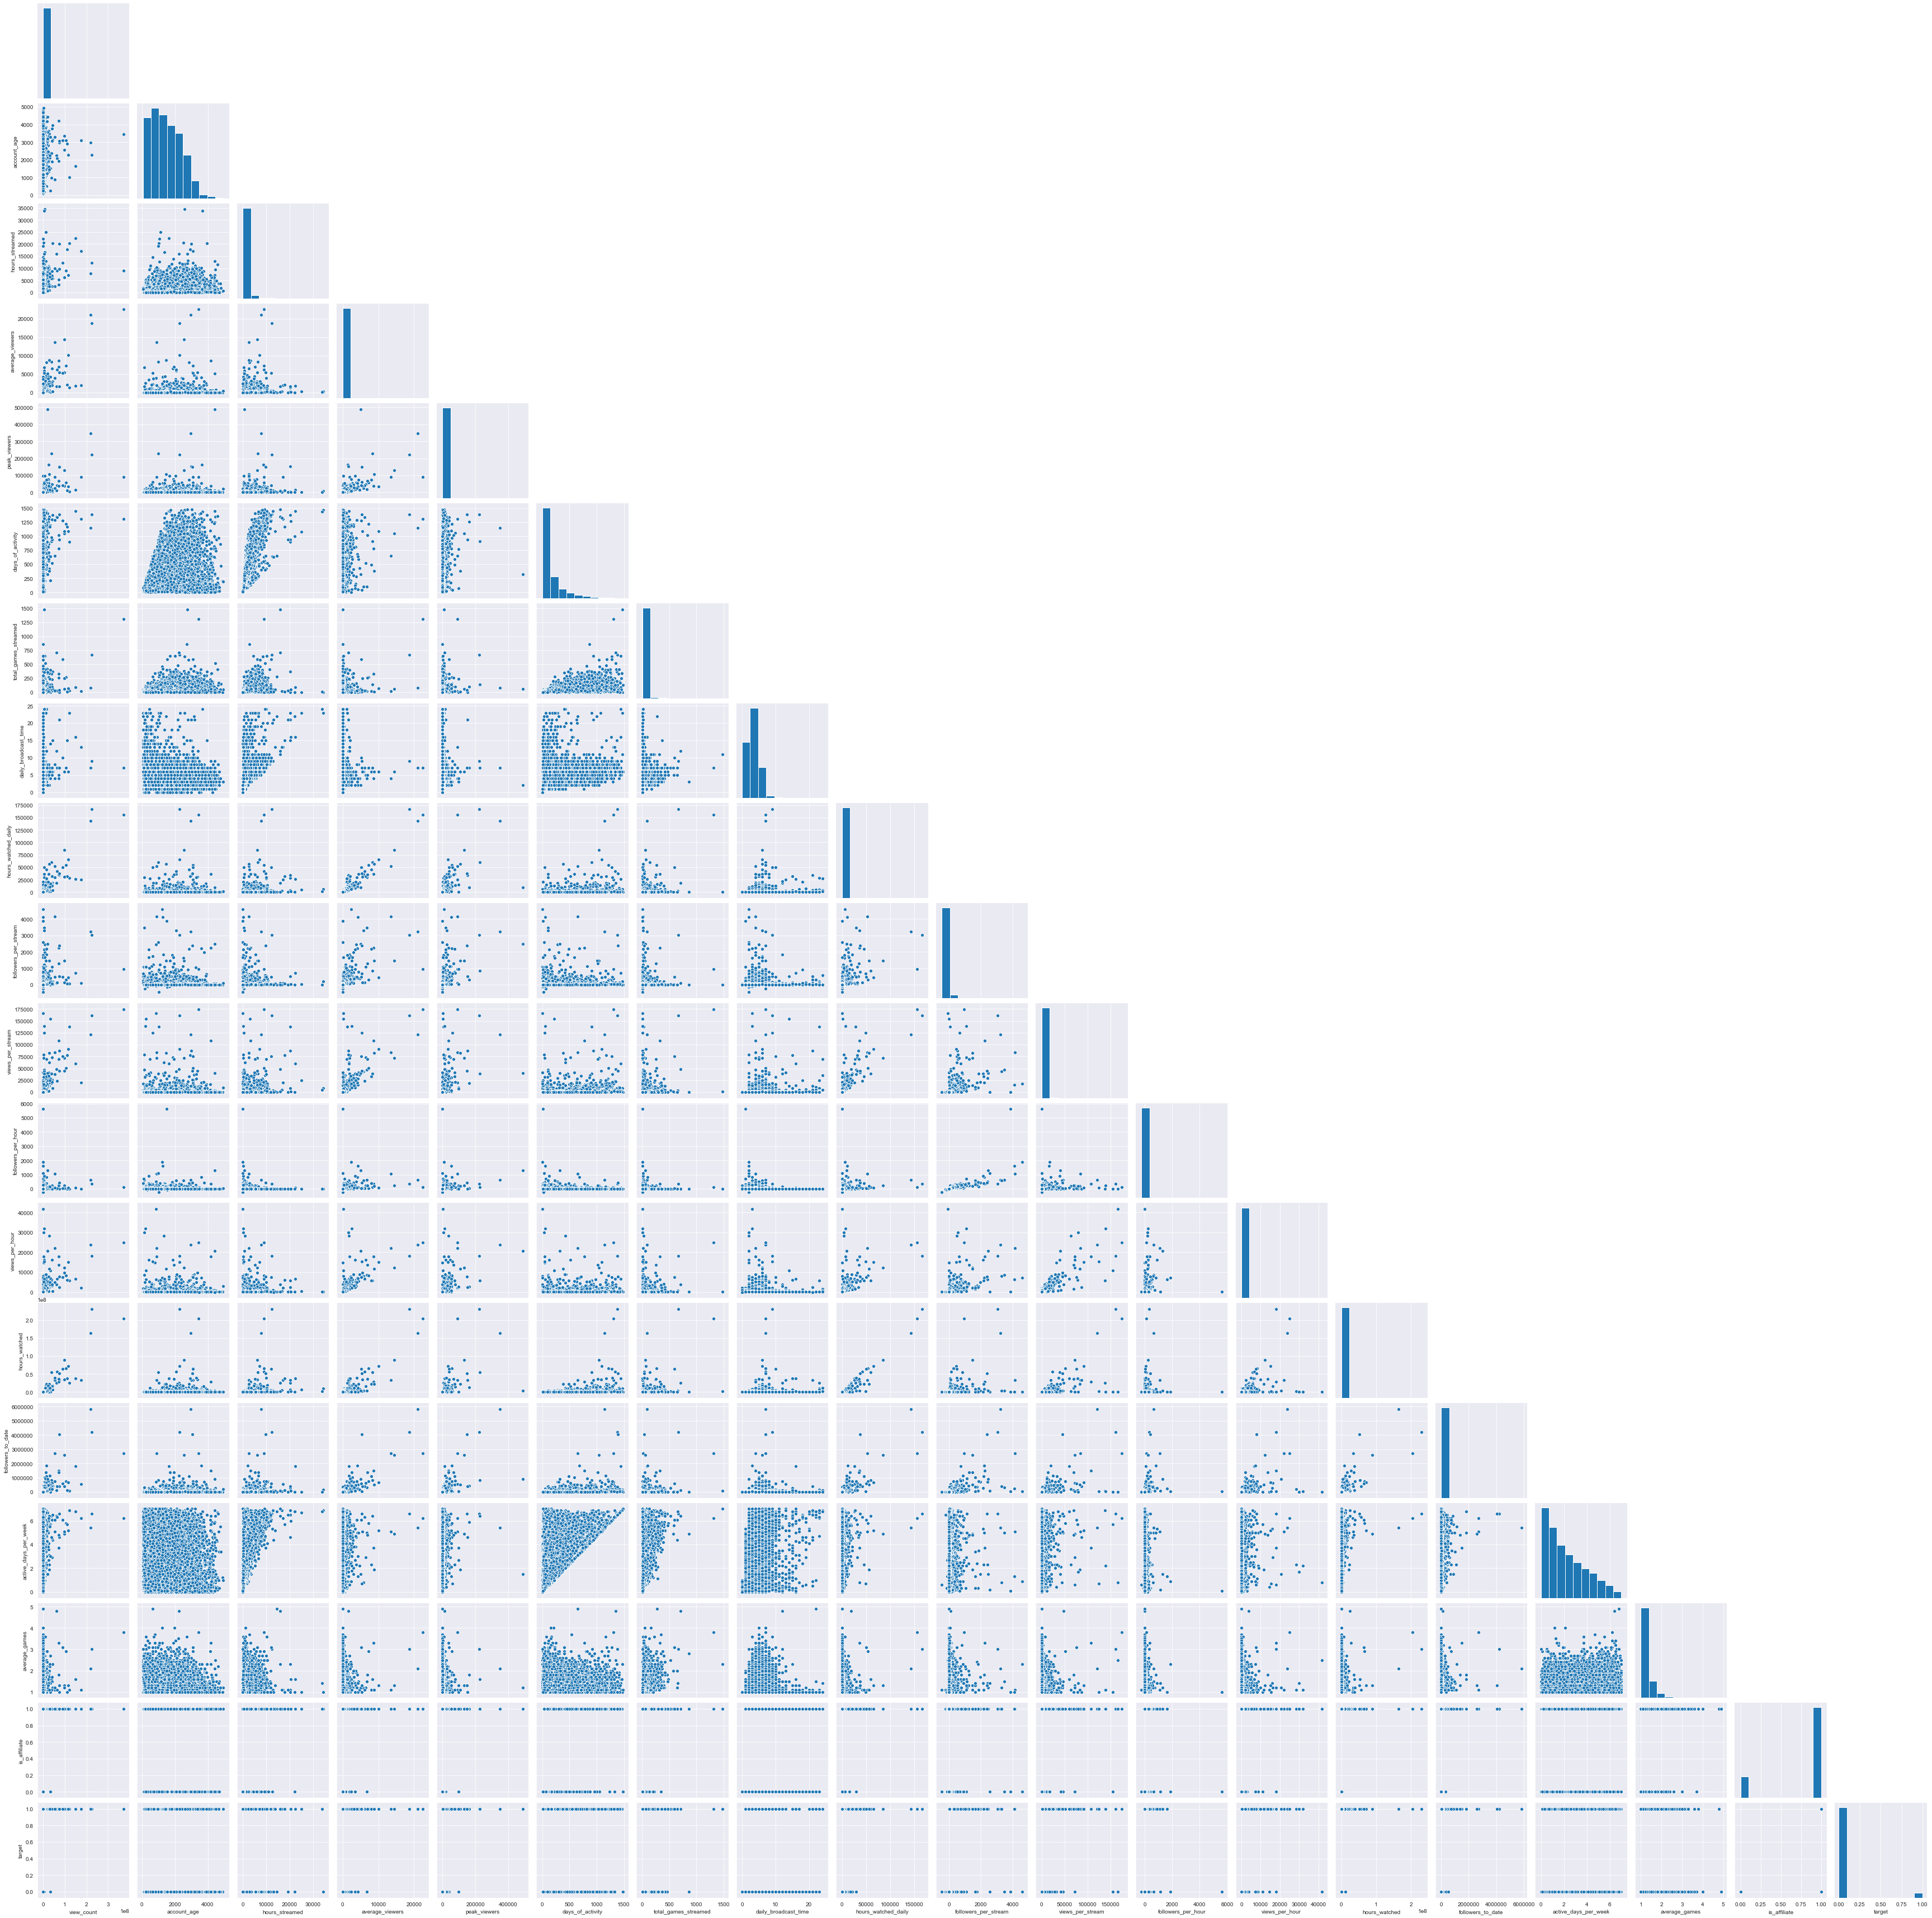

In [89]:
sns.pairplot(df, corner = True);

In [64]:
def bar_plot(column, title, ylabel):
    non_partner = df.loc[df.target == 0][column].median()
    partner = df.loc[df.target == 1][column].median()
    fig, ax = plt.subplots(figsize = (6,3))
    ax.set_title('Median Account Age', fontsize = 14)
    ax.set_ylabel('Account Age in Days', fontsize = 8)
    sns.barplot(y = [non_partner, partner], x = ['non-partner', 'partner'], color='b', alpha=0.7);
    return

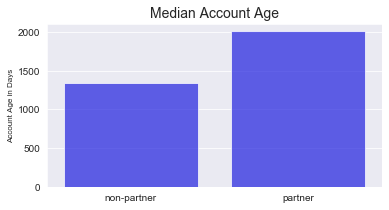

In [65]:
bar_plot(column = 'account_age',
         title = 'Median Account Age',
         ylabel= 'Account Age in Days')

In [80]:
def hist_plot(column):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (6,3))
    ax1.set_title('Unpartnered')
    ax2.set_title('Partnered')
    sns.distplot(df.loc[df.target == 0][column], ax = ax1)
    sns.distplot(df.loc[df.target == 1][column], ax = ax2)
    return

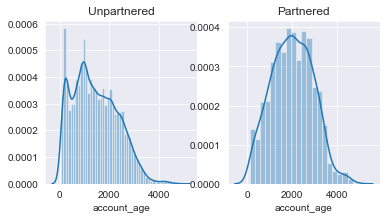

In [81]:
hist_plot('account_age')

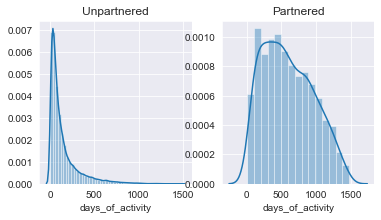

In [84]:
hist_plot('days_of_activity')

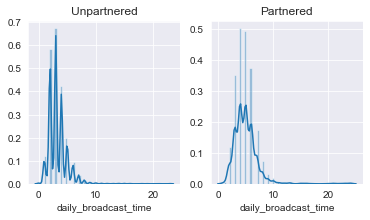

In [86]:
hist_plot('daily_broadcast_time')

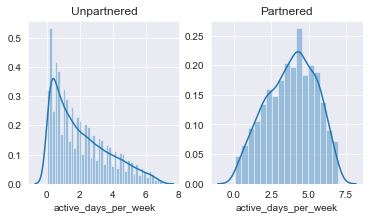

In [87]:
hist_plot('active_days_per_week')

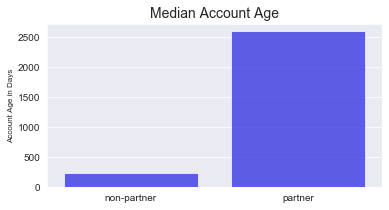

In [66]:
bar_plot(column = 'hours_streamed', 
         title = 'Median Hours Streamed', 
         ylabel = 'Hours streamed')

In [95]:
X = df.drop(columns = 'target')
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

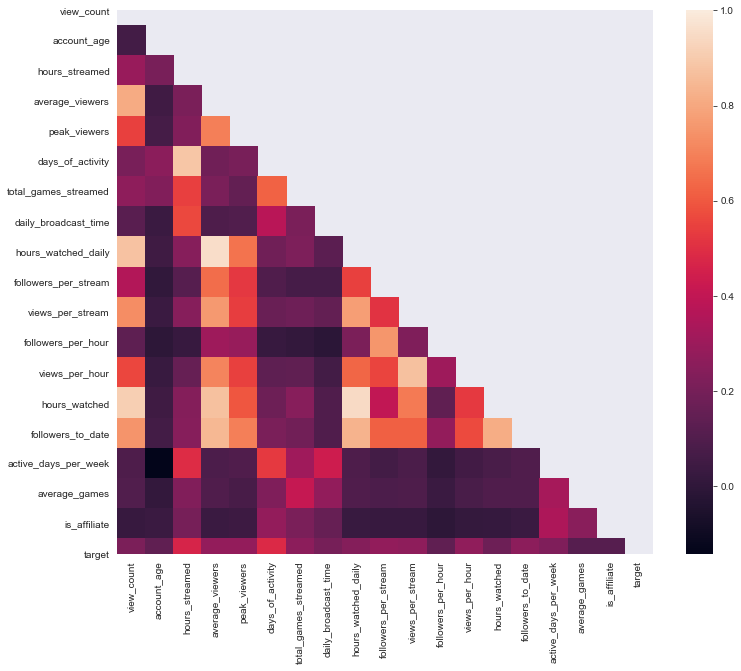

In [96]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(corr, mask = mask)

## Model